# DeeplabV3+ Drone Imagery

Run on Google Chrome for every cell to function properly.    
    
    

---






# Set Up DeeplabV3+

---



This Google Colab Notebook follows very closely the DepthAI Tutorial  
https://github.com/luxonis/depthai-ml-training

other resources with important information:  
https://www.analyticsvidhya.com/blog/2019/02/tutorial-semantic-segmentation-google-deeplab/  
https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb#scrollTo=edGukUHXyymr

Enable GPU runtime-> change runtime type

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun  9 08:46:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Tensorflow version




In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


Libraries

In [ ]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import tensorflow as tf
from google.colab.patches import cv2_imshow
import cv2
from skimage.transform import resize

Install tf_slim:  
TensorFlow-Slim: A lightweight library for defining, training and evaluating complex models in TensorFlow.

In [ ]:
!pip install tf_slim==1.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 3.8 MB/s 


Download subdirectories from tensorflow/models

In [ ]:
!apt install subversion
# subversion --> svn used to download subversion repositories and not the whole repository

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,235 kB of archives.
After this operation, 9,916 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/unive

In [ ]:
!svn checkout https://github.com/tensorflow/models/trunk/research/deeplab
!svn checkout https://github.com/tensorflow/models/trunk/research/slim

# The Checkout command is used to copy the files from the SVN repository to the working copy.
# The checkout operation creates a working copy of the repository where we can edit, delete, or add contents.

# DeepLab: Deep Labelling for Semantic Image Segmentation
# TensorFlow-Slim image classification model library

A    deeplab/README.md
A    deeplab/__init__.py
A    deeplab/common.py
A    deeplab/common_test.py
A    deeplab/convert_to_tflite.py
A    deeplab/core
A    deeplab/core/__init__.py
A    deeplab/core/conv2d_ws.py
A    deeplab/core/conv2d_ws_test.py
A    deeplab/core/dense_prediction_cell.py
A    deeplab/core/dense_prediction_cell_branch5_top1_cityscapes.json
A    deeplab/core/dense_prediction_cell_test.py
A    deeplab/core/feature_extractor.py
A    deeplab/core/nas_cell.py
A    deeplab/core/nas_genotypes.py
A    deeplab/core/nas_network.py
A    deeplab/core/nas_network_test.py
A    deeplab/core/preprocess_utils.py
A    deeplab/core/preprocess_utils_test.py
A    deeplab/core/resnet_v1_beta.py
A    deeplab/core/resnet_v1_beta_test.py
A    deeplab/core/utils.py
A    deeplab/core/utils_test.py
A    deeplab/core/xception.py
A    deeplab/core/xception_test.py
A    deeplab/datasets
A    deeplab/datasets/__init__.py
A    deeplab/datasets/build_ade20k_data.py
A    deeplab/datasets/build_cityscap

Working directory

In [ ]:
% cd /content/deeplab/

/content/deeplab


Set up directory structure

In [ ]:
Datasets="datasets"
Custom_Dataset="custom_dataset"
Exp_Folder="exp"
# placeholder for strings

!mkdir -p $Datasets/$Custom_Dataset/init_models
!mkdir -p $Datasets/$Custom_Dataset/$Exp_Folder/train
!mkdir -p $Datasets/$Custom_Dataset/$Exp_Folder/eval
!mkdir -p $Datasets/$Custom_Dataset/$Exp_Folder/vis
!mkdir -p $Datasets/$Custom_Dataset/$Exp_Folder/export
!mkdir -p $Datasets/$Custom_Dataset/tfrecord
#mkdir -p creates directories as described. Creates parent directories if non existent.

# Modify data_generator.py


---


Add custom dataset to python file  /content/deeplab/datasets/data_generator.py in Google Colab   


Modified version in github folder Files changes: 
https://github.com/ktruong-civ/DeepLabV3-Drone-Imagery.git

In [ ]:
# Material dataset example
# train set 180
# val set 20
# trainval or total 200
# classes 5 (background, plaster, windows, roof tiles, steel pipes)
# 255 or white is used as an ignore label

# data_generator.py modifcation:
"""
_PQR_INFORMATION = DatasetDescriptor(
splits_to_sizes={
  'train': 180,
  'val': 20,
  'trainval': 200,
},
num_classes=5,
ignore_label=255,
)

...

_DATASETS_INFORMATION = {
    'cityscapes': _CITYSCAPES_INFORMATION,
    'pascal_voc_seg': _PASCAL_VOC_SEG_INFORMATION,
    'ade20k': _ADE20K_INFORMATION,
    'pqr': _PQR_INFORMATION,
}
"""

# Import TFRecord Dataset


---



Drag & Drop TFRecords into the created tfrecord folder 
/content/deeplab/datasets/custom_dataset/tfrecord  
12 Tfrecord files in github folder Material/PQR/tfrecords:https://github.com/ktruong-civ/DeepLabV3-Drone-Imagery.git

# Transfer Learning

---



Download pretrained Model deeplabv3_mnv2 on the PASCAL dataset from tensorflow. 

In [ ]:
Pretrained_Model = "deeplabv3_mnv2_cityscapes_train"
Pretrained_Version = "_2018_02_05.tar.gz"

%cd $Datasets/$Custom_Dataset/init_models
# load into init_models directory

!wget -nd -c http://download.tensorflow.org/models/$Pretrained_Model$Pretrained_Version

# !wget download files from the web 

# -nd ‘--no-directories’ Do not create a hierarchy of directories when retrieving recursively. 
# With this option turned on, all files will get saved to the current directory, without clobbering 
# (if a name shows up more than once, the filenames will get extensions ‘.n’).

# -c continue partialy downloaded files


!tar -xf $Pretrained_Model$Pretrained_Version
# tar -xf archive.tar
# Extract all files from archive.tar. 


% cd /content/deeplab

/content/deeplab/datasets/custom_dataset/init_models
--2022-06-09 08:52:32--  http://download.tensorflow.org/models/deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.8.128, 2404:6800:4008:c15::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.8.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23885666 (23M) [application/x-tar]
Saving to: ‘deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz’

deeplabv3_mnv2_city 100%[===================>]  22.78M  24.2MB/s    in 0.9s    

2022-06-09 08:52:34 (24.2 MB/s) - ‘deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz’ saved [23885666/23885666]

/content/deeplab


# Testing Setup


---



In [ ]:
import os

os.environ['PYTHONPATH'] += ":/content/:/content/slim/"
! python model_test.py

# run model_test.py provided in the deeplab directory


Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] DeeplabModelTest.testBuildDeepLabWithDensePredictionCell
Instructions for updating:
Use `self.session()` or `self.cached_session()` instead.
W0609 08:52:42.707734 140659044693888 deprecation.py:323] From /usr/lib/python3.7/contextlib.py:82: TensorFlowTestCase.test_session (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `self.session()` or `self.cached_session()` instead.
2022-06-09 08:52:42.709337: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-09 08:52:42.778954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 08:52:42.779639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties:

# Training

---




Configuration

In [ ]:
OUTPUT_STRIDE = 16
# larger faster but might cause excissive decimation (worse performance)

BATCH_SIZE = 4
# Can be set higher if the GPU can handle it

CROP_SIZE = 512
# Crop and input size of the model. Multiple of OUTPUT_STRIDE

NUM_ITERATIONS = 70000
# Number of training steps

INIT_CKPT = f"/content/deeplab/{Datasets}/{Custom_Dataset}/init_models/{Pretrained_Model}/model.ckpt"
LOG_DIR_TRAIN = f"/content/deeplab/{Datasets}/{Custom_Dataset}/{Exp_Folder}/train"
DATASET_PATH = f"/content/deeplab/{Datasets}/{Custom_Dataset}/tfrecord"
CROP_SIZE_TXT = f"{CROP_SIZE+1},{CROP_SIZE+1}"
# Path setup

# f strings for formating. 
# Datasets="datasets" 
# f"/content/deeplab/{Datasets}"/ --> "/content/deeplab/datasets/"

Training script

In [ ]:
#Training script  
#Configuration/FLAGS:  
#train_split: choose dataset to train on  
#model_variant: choose pretrained model (needs to be downloaded above)  
#fine_tune_batch_norm: false for faster training but worse performance  
#tf_initial_checkpoint: checkpoints  
#train_logdir: log  
#dataset_dir: tfrecord dataset

In [ ]:
! python train.py \
--logtostderr \
--train_split="train" \
--model_variant="mobilenet_v2" \
--output_stride=$OUTPUT_STRIDE \
--train_crop_size=$CROP_SIZE_TXT \
--train_batch_size=$BATCH_SIZE \
--training_number_of_steps=$NUM_ITERATIONS \
--initialize_last_layer=False \
--last_layers_contain_logits_only=False \
--fine_tune_batch_norm=True \
--label_weights=1 \
--label_weights=1 \
--label_weights=10 \
--label_weights=1 \
--label_weights=20 \
--base_learning_rate=0.001 \
--learning_rate_decay_step=60000 \
--dataset="pqr" \
--tf_initial_checkpoint=$INIT_CKPT \
--train_logdir=$LOG_DIR_TRAIN \
--dataset_dir=$DATASET_PATH \


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0609 17:03:40.457849 139704503707520 module_wrapper.py:139] From train.py:274: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W0609 17:03:40.458045 139704503707520 module_wrapper.py:139] From train.py:274: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W0609 17:03:40.458234 139704503707520 module_wrapper.py:139] From train.py:289: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0609 17:03:40.458381 139704503707520 module_wrapper.py:139] From train.py:290: The name tf.logging.info is deprec

# Evaluation

---



In [ ]:
LOG_DIR_EVAL = f"/content/deeplab/{Datasets}/{Custom_Dataset}/{Exp_Folder}/eval"
# Set up directory

Configurations:
eval_crop_size should be larger than the largest image in the validation set

In [ ]:
! python eval.py \
--logtostderr \
--eval_split="val" \
--model_variant="mobilenet_v2" \
--eval_crop_size=1081,1921 \
--dataset="pqr" \
--checkpoint_dir=$LOG_DIR_TRAIN \
--eval_logdir=$LOG_DIR_EVAL \
--dataset_dir=$DATASET_PATH \
--max_number_of_evaluations=1




W0609 18:20:57.645547 140514750297984 module_wrapper.py:139] From eval.py:91: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W0609 18:20:57.645716 140514750297984 module_wrapper.py:139] From eval.py:91: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W0609 18:20:57.645922 140514750297984 module_wrapper.py:139] From eval.py:108: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0609 18:20:57.646095 140514750297984 module_wrapper.py:139] From eval.py:109: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

INFO:tensorflow:Evaluating on val set
I0609 18:20:57.646191 140514750297984 eval.py:109] Evaluating on val set
W0609 18:20:57.680122 140514750297984 ag_logging.py:146] Entity <bound method Dataset._parse_function of <deeplab.datasets.data_generator.Dataset object at 0x7fcbbb97b550>> could not be transformed and will

# Results

---



Visualize results

In [ ]:
LOG_DIR_VIS = f"/content/deeplab/{Datasets}/{Custom_Dataset}/{Exp_Folder}/vis"

In [ ]:
! python vis.py \
--logtostderr \
--vis_split="trainval" \
--model_variant="mobilenet_v2" \
--vis_crop_size=1081,1921 \
--dataset="pqr" \
--checkpoint_dir=$LOG_DIR_TRAIN \
--vis_logdir=$LOG_DIR_VIS \
--dataset_dir=$DATASET_PATH \
--max_number_of_iterations=1







W0609 18:23:24.810577 139899577530240 module_wrapper.py:139] From vis.py:195: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W0609 18:23:24.810765 139899577530240 module_wrapper.py:139] From vis.py:195: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W0609 18:23:24.810981 139899577530240 module_wrapper.py:139] From vis.py:218: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0609 18:23:24.811191 139899577530240 module_wrapper.py:139] From vis.py:225: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

INFO:tensorflow:Visualizing on trainval set
I0609 18:23:24.811288 139899577530240 vis.py:225] Visualizing on trainval set
W0609 18:23:24.846956 139899577530240 ag_logging.py:146] Entity <bound method Dataset._parse_function of <deeplab.datasets.data_generator.Dataset object at 0x7f3c80713050>> could not be transformed

Results can be seen in the *vis* directory.

# Export Trained Model

---



In [ ]:
CKPT_PATH=f"{LOG_DIR_TRAIN}/model.ckpt-{NUM_ITERATIONS}"
print(CKPT_PATH)
EXPORT_PATH = f"/content/deeplab/{Datasets}/{Custom_Dataset}/{Exp_Folder}/export/frozen_inference_graph.pb"
print(EXPORT_PATH)

/content/deeplab/datasets/custom_dataset/exp/train/model.ckpt-70000
/content/deeplab/datasets/custom_dataset/exp/export/frozen_inference_graph.pb


In [ ]:
! python export_model.py \
--logtostderr \
--output_stride=16    \
--model_variant="mobilenet_v2" \
--dataset="pqr" \
--crop_size=1081 \
--crop_size=1921 \
--num_classes=5 \
--checkpoint_path=$CKPT_PATH \
--export_path=$EXPORT_PATH \


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0609 18:23:56.158580 139846699079552 module_wrapper.py:139] From export_model.py:117: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W0609 18:23:56.158745 139846699079552 module_wrapper.py:139] From export_model.py:117: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W0609 18:23:56.158885 139846699079552 module_wrapper.py:139] From export_model.py:118: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

INFO:tensorflow:Prepare to export model to: /content/deeplab/datasets/custom_dataset/exp/ex

# Overlay Prediction with Original Image

---




/content/deeplab/datasets/custom_dataset/exp/vis/segmentation_results
/content/deeplab


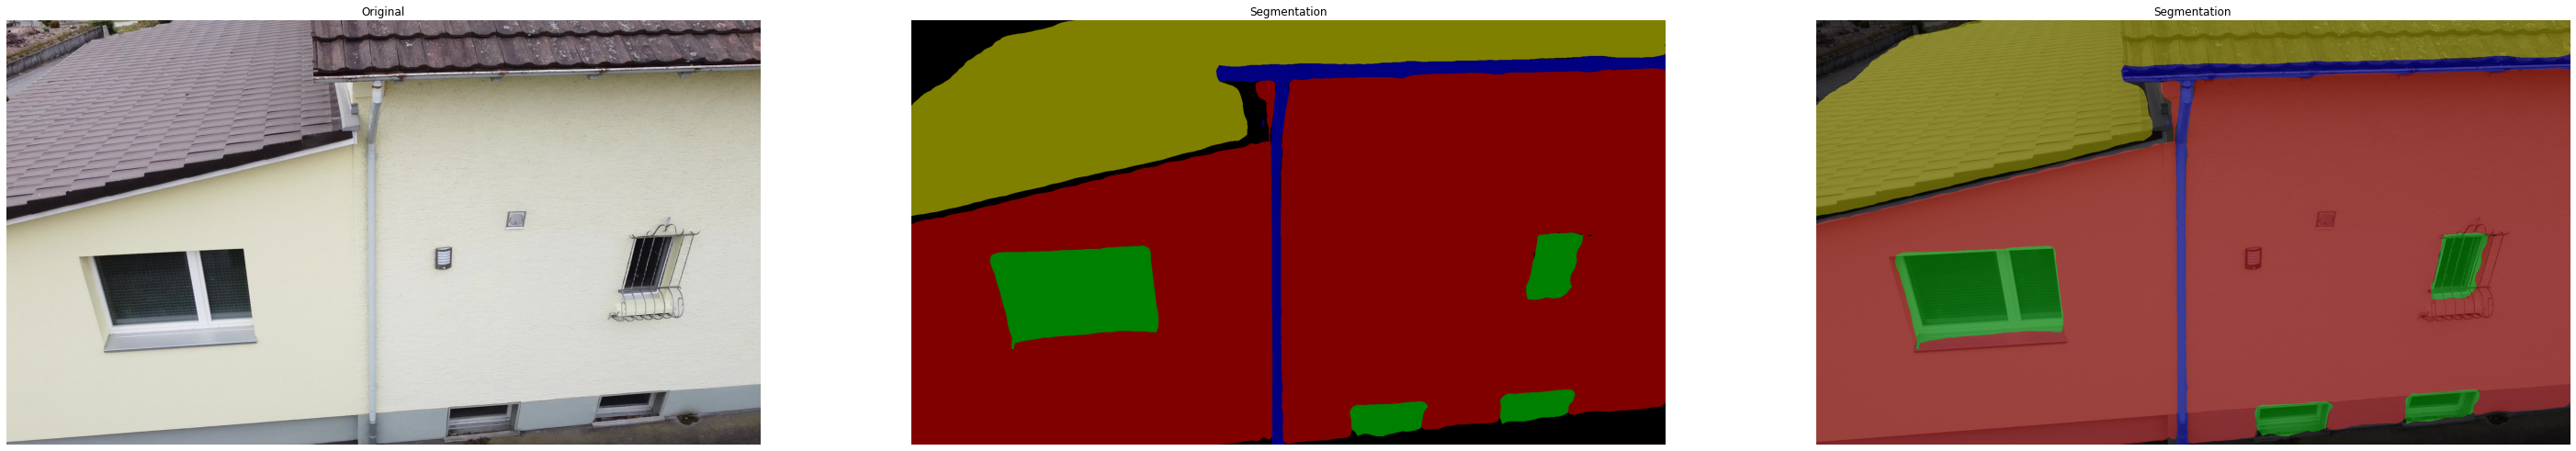

In [ ]:

%cd /content/deeplab/{Datasets}/{Custom_Dataset}/{Exp_Folder}/vis/segmentation_results

prediction ="000010"
image = "{}_image.png".format(prediction)
segm = "{}_prediction.png".format(prediction)


fig = plt.figure(figsize=(50, 35))
rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(mpimg.imread(image))
plt.axis('off')
plt.title("Original")

fig.add_subplot(rows, columns, 2)
plt.imshow(mpimg.imread(segm))
plt.axis('off')
plt.title("Segmentation")

fig.add_subplot(rows, columns, 3)
plt.imshow(mpimg.imread(image))
plt.imshow(mpimg.imread(segm), alpha=0.7)
plt.axis('off')
plt.title("Segmentation")

%cd /content/deeplab

# Download frozen_inference_graph.pb
Download the frozen model /content/deeplab/datasets/custom_dataset/exp/export/frozen_inference_graph.pb

